### Fatal Police Shootings in the US

#### The Washington Post's database contains records of every fatal shooting in the United States by a police officer in the line of duty since Jan. 1, 2015.


EDA to quantitatively answer the following: 
1. Killings per period 
2. Manner of deaths 
3. Victims armed or not 
4. Age ranges and distribution of victims 
5. Killings per gender 
6. Killings per race 
7. Top 10 States with the highest kills
8. Signs of mental illness of victims 
9. Victims threating police officers
10. Trend: fatal shooting of blacks, whites, and hispanics (2015 - 2021)
11. Body cameras present

Dataset: https://github.com/washingtonpost/data-police-shootings

Tableau Dashboard: https://public.tableau.com/app/profile/ikenna4609/viz/PoliceKillingsintheUSA/PoliceKillingsintheUSA?publish=yes

In [27]:
import pandas as pd
from pandas import DataFrame
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
url = 'https://github.com/washingtonpost/data-police-shootings/blob/a5f12f226446b66136e70e90823d71c4fbedffb4/fatal-police-shootings-data.csv?raw=True'
fatal_shootings = pd.read_csv(url)

In [29]:
fatal_shootings

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,7410,NaN,2021-12-08,shot,knife,NaN,M,NaN,Colorado Springs,CO,False,undetermined,Not fleeing,False,NaN,NaN,True
6796,7415,NaN,2021-12-08,shot,gun,NaN,NaN,NaN,Columbus,OH,False,undetermined,Not fleeing,False,NaN,NaN,True
6797,7416,NaN,2021-12-08,shot,gun,NaN,M,NaN,Stockton,CA,False,undetermined,Not fleeing,False,NaN,NaN,True
6798,7412,NaN,2021-12-09,shot,undetermined,NaN,M,NaN,Henry County,GA,False,undetermined,Car,False,NaN,NaN,True


In [30]:
fatal_shootings.shape

(6800, 17)

### Clean up

In [31]:
#NaNs
fatal_shootings.isna().sum()

id                           0
name                       284
date                         0
manner_of_death              0
armed                      207
age                        340
gender                       8
race                       945
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                       537
body_camera                  0
longitude                  385
latitude                   385
is_geocoding_exact           0
dtype: int64

In [32]:
#percentage of data missing 
missing = fatal_shootings.isna().sum()
missing_count = missing.sum()
total = fatal_shootings.shape[0]

missing_percentage = (missing_count/total)*100 
missing_percentage

45.455882352941174

In [33]:
#replace missing values 
fatal_shootings.fillna({'name':'unknown', 
                        'gender':'unknown', 
                        'race':'unknown', 
                        'flee':'unknown', 
                        'armed':'undetermined'}, inplace=True)

In [34]:
fatal_shootings.date.dtype #date is object datetype

#convert 'date' column to datetime

fatal_shootings.date = pd.to_datetime(fatal_shootings.date, format='%Y-%m-%d')
fatal_shootings['year'] = fatal_shootings.date.dt.year
fatal_shootings.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2015
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,2015
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,2015
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,2015


In [35]:
#create a new field to hold the ffg categories - armed, unarmed, undetermined, unknown
#create a list for the conditions 
conditions = [
    (fatal_shootings['armed'] == 'unarmed'), 
    (fatal_shootings['armed'] == 'undetermined'), 
    (fatal_shootings['armed'] == 'unknown weapon'),
    (fatal_shootings['armed'] == fatal_shootings['armed'])
]

#create a list of values to be assigned for each condition
values = ['unarmed', 'undetermined', 'unknown', 'armed']

#create new column and use np.select to assign values to it using our lists as arguments
fatal_shootings['victim_armed'] = np.select(conditions, values)

In [36]:
fatal_shootings

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,year,victim_armed
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,2015,armed
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,2015,armed
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,2015,unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,2015,armed
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,2015,armed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,7410,unknown,2021-12-08,shot,knife,NaN,M,unknown,Colorado Springs,CO,False,undetermined,Not fleeing,False,NaN,NaN,True,2021,armed
6796,7415,unknown,2021-12-08,shot,gun,NaN,unknown,unknown,Columbus,OH,False,undetermined,Not fleeing,False,NaN,NaN,True,2021,armed
6797,7416,unknown,2021-12-08,shot,gun,NaN,M,unknown,Stockton,CA,False,undetermined,Not fleeing,False,NaN,NaN,True,2021,armed
6798,7412,unknown,2021-12-09,shot,undetermined,NaN,M,unknown,Henry County,GA,False,undetermined,Car,False,NaN,NaN,True,2021,undetermined


### Q1. Killings Per Period

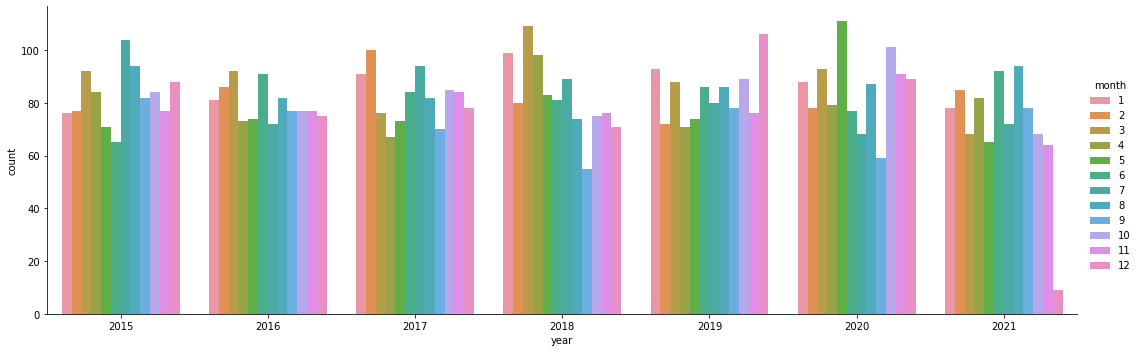

In [37]:
fatal_shootings['month'] = fatal_shootings.date.dt.month
fatal_shootings['year'] = fatal_shootings.date.dt.year

sns.catplot(data=fatal_shootings,kind='count',x='year',hue='month', aspect=3)



### Q2. Manner of deaths

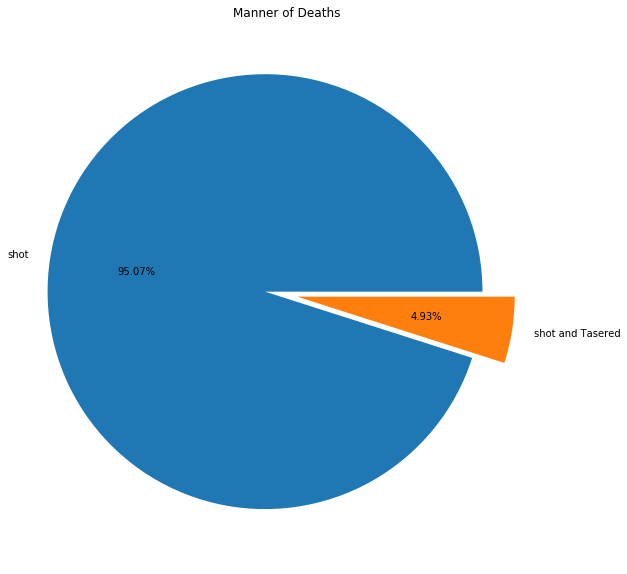

In [38]:
manner_of_death = fatal_shootings.manner_of_death.value_counts().rename_axis('Manner of Death').reset_index(name='Count')

death_manner = manner_of_death['Manner of Death']
count = manner_of_death.Count
labels = death_manner

plt.pie(count, labels=labels, autopct='%.2f%%', explode=[0.1,0.05])
plt.title('Manner of Deaths')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

### Q3. Victims armed?

armed: indicates that the victim was armed with some sort of implement that a police officer believed could inflict harm

    undetermined: it is not known whether or not the victim had a weapon
    unknown: the victim was armed, but it is not known what the object was
    unarmed: the victim was not armed
    armed: the victim was armed with some type of weapon


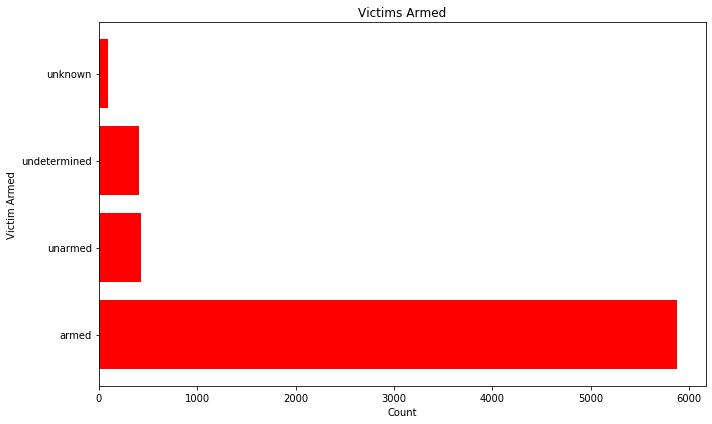

In [39]:
victims_armed = fatal_shootings.victim_armed.value_counts().rename_axis('Armed').reset_index(name='Count')

armed = victims_armed.Armed
counts = victims_armed.Count

plt.figure(figsize=(10, 6))
plt.barh(armed, counts, align='center', height=0.8, color='r')
#plt.xticks(counts)
plt.xlabel('Count')
plt.ylabel('Victim Armed')
plt.title('Victims Armed')
plt.tight_layout()
plt.show()

### Q4. Victims age stratification

1. Children (00-14 years)
2. Youth (15-24 years)
3. Adults (25-64 years)
4. Seniors (65 years and over)

In [40]:
fatal_shootings.age.describe()

count    6460.000000
mean       37.136842
std        12.973654
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        92.000000
Name: age, dtype: float64

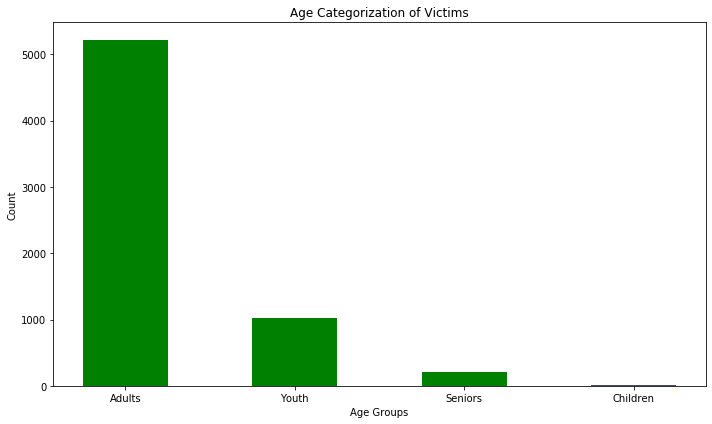

Text(0.5, 1.0, 'Age Distribution of Victims')

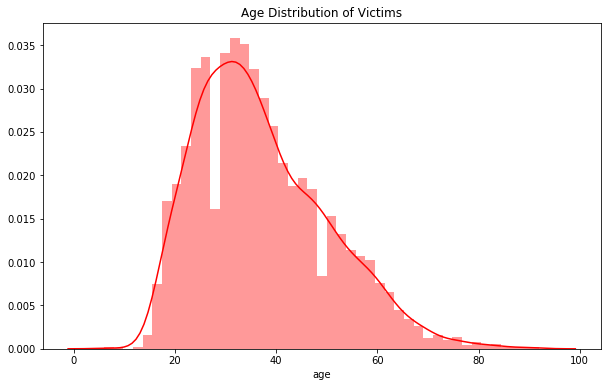

In [41]:
#bin ages 

bins = [0, 15, 25, 65, 110]
labels = ['Children', 'Youth', 'Adults', 'Seniors']
fatal_shootings['binned'] = pd.cut(fatal_shootings['age'], bins=bins, labels=labels, right=False)
age_group = fatal_shootings.binned.value_counts().rename_axis('Age Group').reset_index(name='Count')

plt.figure(figsize=(10, 6))
plt.bar(age_group['Age Group'], age_group.Count, align='center', width=0.5, color='g')
plt.xticks(age_group['Age Group'])
plt.ylabel('Count')
plt.xlabel('Age Groups')
plt.title('Age Categorization of Victims')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.distplot(fatal_shootings['age'],kde=True,color='r').set_title('Age Distribution of Victims')


### Q5. Gender Count Comparison

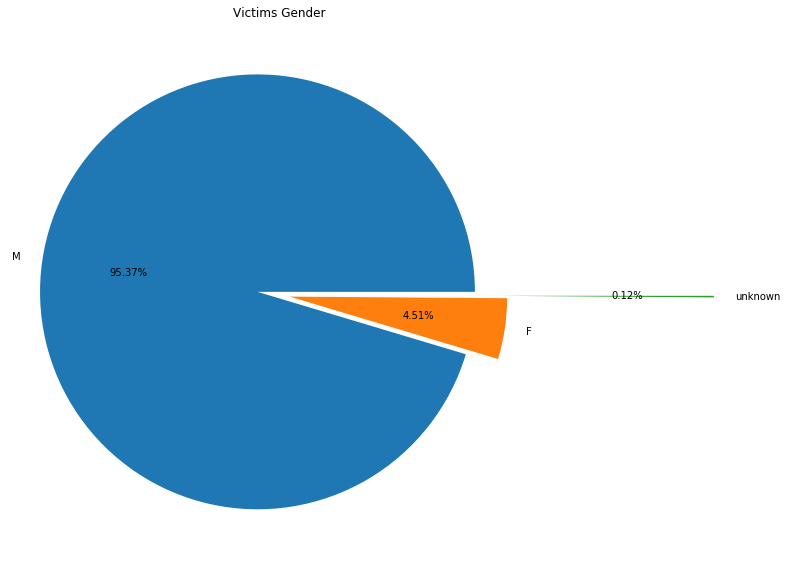

In [42]:
gender_classification = fatal_shootings.gender.value_counts().rename_axis('Gender').reset_index(name='Count')

gender = gender_classification.Gender 
count = gender_classification.Count
labels = gender 


plt.pie(count, labels=labels, autopct='%.2f%%', explode=[0.1,0.05,1])
plt.title('Victims Gender')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

### Q6. Victims' Race


    W: White, non-Hispanic
    B: Black, non-Hispanic
    A: Asian
    N: Native American
    H: Hispanic
    O: Other
    None: unknown


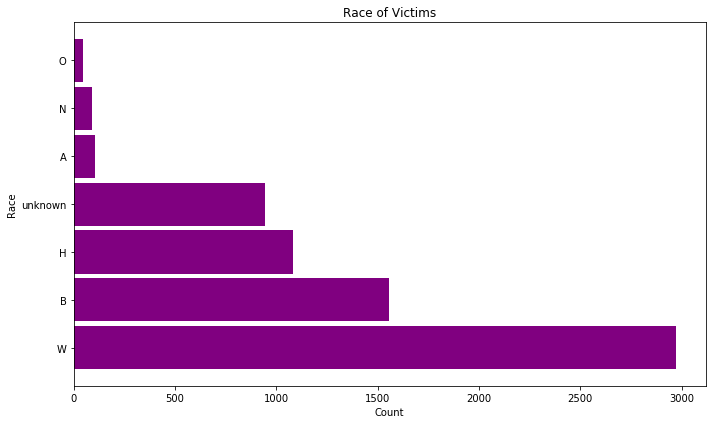

In [43]:
victim_race = fatal_shootings.race.value_counts().rename_axis('Race').reset_index(name='Count')

race = victim_race.Race 
counts = victim_race.Count

plt.figure(figsize=(10, 6))
plt.barh(race, counts, align='center', height=0.9, color='purple')
#plt.xticks(counts)
plt.xlabel('Count')
plt.ylabel('Race')
plt.title('Race of Victims')
plt.tight_layout()
plt.show()

### Q7. Top 10 States - Kill Count

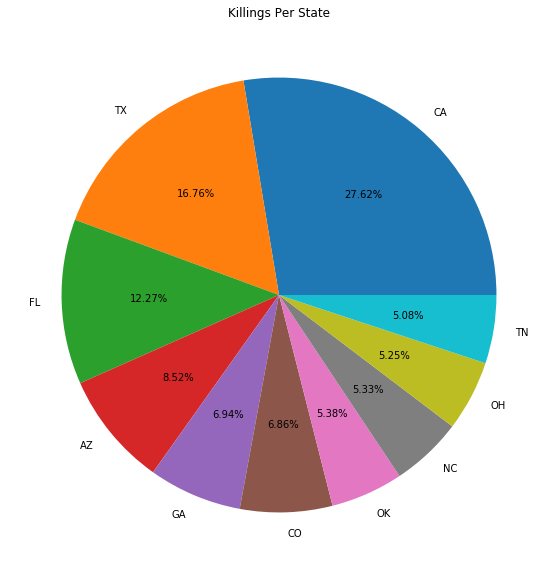

In [44]:
killings_per_state = fatal_shootings.state.value_counts().rename_axis('State').reset_index(name='Count')
top10 = killings_per_state.head(10)

state = top10.State 
count = top10.Count
labels = state 

plt.pie(count, labels=labels, autopct='%.2f%%')
plt.title('Killings Per State')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

### Q8. Signs of Mental Illness

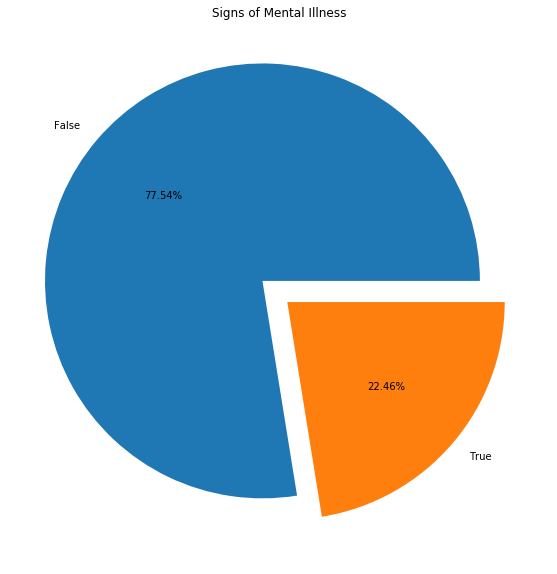

In [45]:
mental_illness = fatal_shootings.signs_of_mental_illness.value_counts().rename_axis('Mental Illness').reset_index(name='Count')

labels = mental_illness['Mental Illness']
count = mental_illness.Count

plt.title('Signs of Mental Illness')
plt.pie(count, labels=labels, autopct='%.2f%%', explode=[0.1,0.05])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

### Q9. Threat Level

The general criteria for the attack label was that there was the most direct and immediate threat to life. 
That would include incidents where officers or others were shot at, threatened with a gun, attacked with other weapons or physical force, etc. 
The attack category is meant to flag the highest level of threat. The other and undetermined categories represent all remaining cases. 
Other includes many incidents where officers or others faced significant threats.

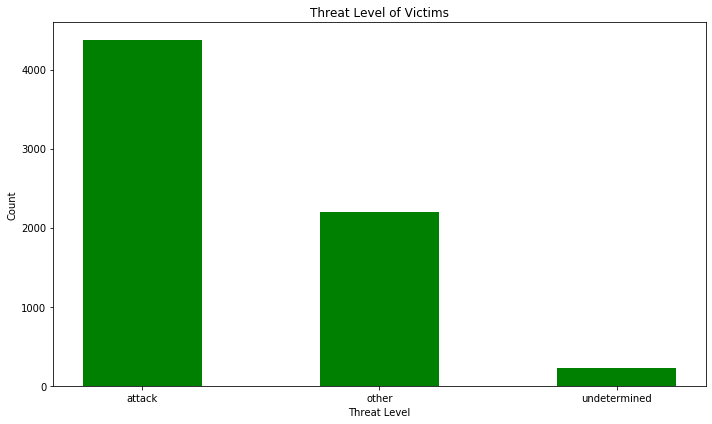

In [46]:
threat_level = fatal_shootings.threat_level.value_counts().rename_axis('Threat Level').reset_index(name='Count')

threat = threat_level['Threat Level']
count = threat_level.Count

plt.figure(figsize=(10, 6))
plt.bar(threat, count, align='center', width=0.5, color='g')
plt.xticks(threat)
plt.ylabel('Count')
plt.xlabel('Threat Level')
plt.title('Threat Level of Victims')
plt.tight_layout()
plt.show()

### Q10. Trends

Fatal shooting trends of blacks, whites, and hispanics

In [47]:
bwh = fatal_shootings.loc[(fatal_shootings.race=='W') | (fatal_shootings.race=='B') | (fatal_shootings.race=='H')]

In [48]:
bwh_trends = pd.DataFrame({'count': bwh.groupby(['year', 'race']).size()}).reset_index()
bwh_trends


,year,race,count
0,2015,B,258
1,2015,H,173
2,2015,W,502
3,2016,B,236
4,2016,H,161
5,2016,W,465
6,2017,B,223
7,2017,H,180
8,2017,W,460
9,2018,B,232


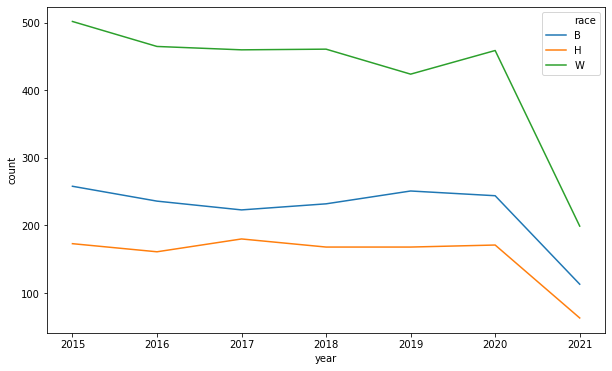

In [49]:
plt.figure(figsize=(10, 6))
sns.lineplot(data = bwh_trends, x = 'year', y = 'count', hue = 'race')
plt.show()

### Q11. Body Cameras Present - True/False

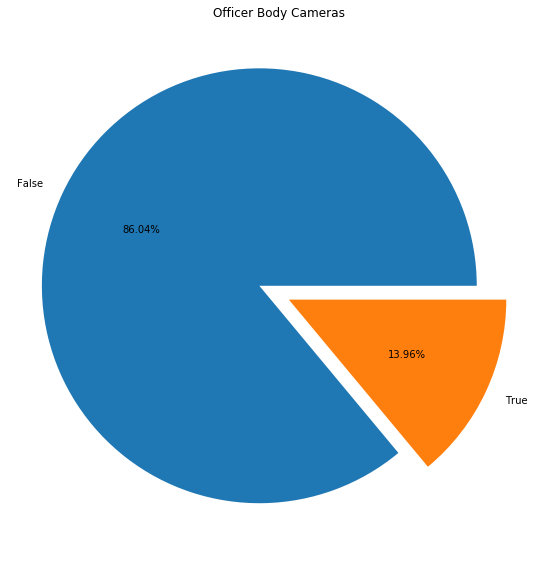

In [50]:
cam = fatal_shootings.body_camera.value_counts().rename_axis('body camera').reset_index(name='Count')
cam

labels = cam['body camera']
count = cam.Count

plt.title('Officer Body Cameras')
plt.pie(count, labels=labels, autopct='%.2f%%', explode=[0.1,0.05])
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [51]:
fatal_shootings.to_excel(os.path.join(output_path, 'police_killings_USA.xlsx'), index=False)

In [52]:
fatal_shootings.date.max()

Timestamp('2021-12-10 00:00:00')